# **Project Title:**
# **Sentiment Analysis and Rating Prediction Using Amazon Product Reviews**

By: Nadya Malekpour

CMPE-257 | Machine Learning | Summer 2024

------------------------------------------
# Introduction:

**Background:**

Customer reviews are essential for e-commerce platforms as they offer valuable insights into customer satisfaction and product quality. Analyzing these reviews helps businesses enhance their products and services.

**Objective:**

The primary goals of this project are:

Sentiment Analysis: Classify review sentiments into positive, negative, or neutral categories.

Rating Prediction: Predict product ratings based on review text and other features.

Identify Key Influencing Factors: Discover what drives customer satisfaction and dissatisfaction.

# Dataset:

**Source:**

Amazon Product Reviews.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud

#Loading the dataset
data = pd.read_csv('/content/amazon_review.csv')

#Displaying the first and last few rows to understand the structure of dataset
print(data.head())
print(data.tail())

#Check the column name
print("\n\n", data.columns)

       reviewerID        asin  reviewerName helpful  \
0  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]   
1  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]   
2  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]   
3   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]   
4  A375ZM4U047O79  B007WTAJTO  2&amp;1/2Men  [0, 0]   

                                          reviewText  overall  \
0                                         No issues.      4.0   
1  Purchased this for my device, it worked as adv...      5.0   
2  it works as expected. I should have sprung for...      4.0   
3  This think has worked out great.Had a diff. br...      5.0   
4  Bought it with Retail Packaging, arrived legit...      5.0   

                                  summary  unixReviewTime  reviewTime  \
0                              Four Stars      1406073600  2014-07-23   
1                           MOAR SPACE!!!      1382659200  2013-10-25   
2               nothing to really say....      1356220800  



---


# Data Quality and Data Preprocessing :

Missing values:
reviewerID        0
asin              0
reviewerName      1
helpful           0
reviewText        1
overall           0
summary           0
unixReviewTime    0
reviewTime        0
day_diff          0
helpful_yes       0
total_vote        0
date              0
dtype: int64

Number of duplicate entries: 0

Data types:
reviewerID                object
asin                      object
reviewerName              object
helpful                   object
reviewText                object
overall                  float64
summary                   object
unixReviewTime             int64
reviewTime                object
day_diff                   int64
helpful_yes                int64
total_vote                 int64
date              datetime64[ns]
dtype: object

Number of unique reviewers: 4913

Number of unique products: 1


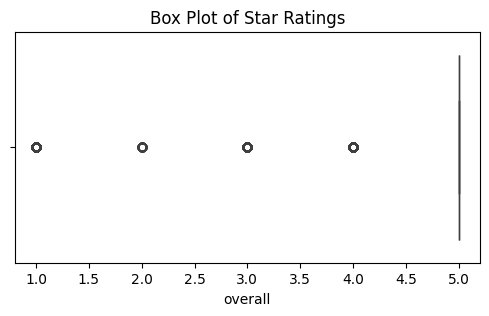


Number of outliers in ratings: 992


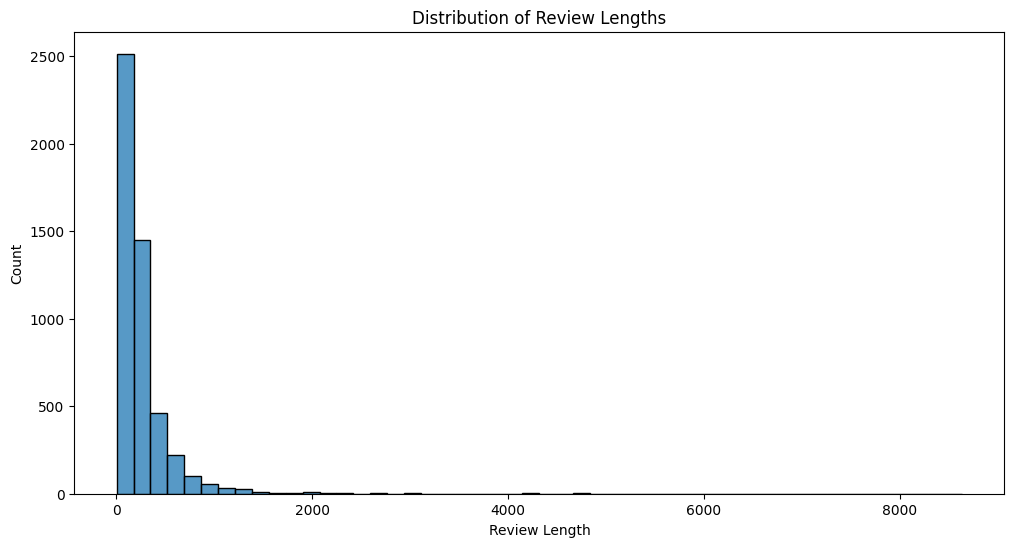


Number of unusually short reviews: 50
Number of unusually long reviews: 50

Data Quality and Outlier Summary:
Total number of reviews: 4913
Missing values after cleaning: 0
Duplicate entries after cleaning: 0
Outliers in ratings: 992
Unusually short reviews: 50
Unusually long reviews: 50


In [2]:
# Convert timestamp to datetime
data['date'] = pd.to_datetime(data['unixReviewTime'], unit='s')

# 1. Data Quality Assessment

# Check for missing values
print("Missing values:")
missing_values = data.isnull().sum()
print(missing_values)

# Handle missing values (if any)
# For simplicity, we could drop rows with missing values or fill them with a placeholder.
data = data.dropna()  # Or: data = data.fillna('')

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate entries: {duplicates}")

# Drop duplicates if any
data = data.drop_duplicates()

# Validate data types
print("\nData types:")
print(data.dtypes)

# Check for inconsistencies in product IDs
unique_reviewers = data['reviewerID'].nunique()
print(f"\nNumber of unique reviewers: {unique_reviewers}")

# Check for inconsistencies in product categories or IDs
unique_products = data['asin'].nunique()  # assuming 'asin' is the product ID column
print(f"\nNumber of unique products: {unique_products}")

# 2. Outlier Detection

# For ratings
plt.figure(figsize=(6, 3))
sns.boxplot(x=data['overall'])
plt.title('Box Plot of Star Ratings')
plt.show()

# Detecting outliers using the IQR method for ratings
Q1 = data['overall'].quantile(0.25)
Q3 = data['overall'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['overall'] < lower_bound) | (data['overall'] > upper_bound)]
print(f"\nNumber of outliers in ratings: {len(outliers)}")

# For review text (if present)
if 'reviewText' in data.columns:
    data['review_length'] = data['reviewText'].str.len()

    plt.figure(figsize=(12, 6))
    sns.histplot(data=data, x='review_length', bins=50)
    plt.title('Distribution of Review Lengths')
    plt.xlabel('Review Length')
    plt.show()

    # Identify unusually short or long reviews
    short_reviews = data[data['review_length'] < data['review_length'].quantile(0.01)]
    long_reviews = data[data['review_length'] > data['review_length'].quantile(0.99)]

    print(f"\nNumber of unusually short reviews: {len(short_reviews)}")
    print(f"Number of unusually long reviews: {len(long_reviews)}")

# 3. Summary of findings
print("\nData Quality and Outlier Summary:")
print(f"Total number of reviews: {len(data)}")
print(f"Missing values after cleaning: {data.isnull().sum().sum()}")
print(f"Duplicate entries after cleaning: {data.duplicated().sum()}")
print(f"Outliers in ratings: {len(outliers)}")
if 'reviewText' in data.columns:
    print(f"Unusually short reviews: {len(short_reviews)}")
    print(f"Unusually long reviews: {len(long_reviews)}")




---


# Exploratory Data Analysis (EDA):

Understanding the distribution of ratings, the frequency and content of reviews, and trends over time.

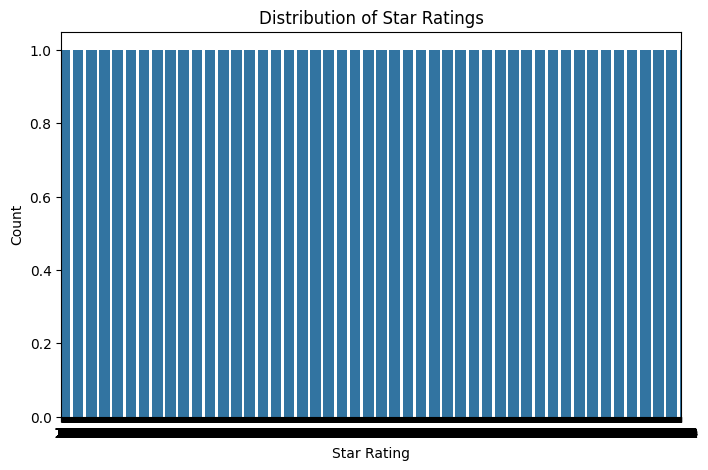

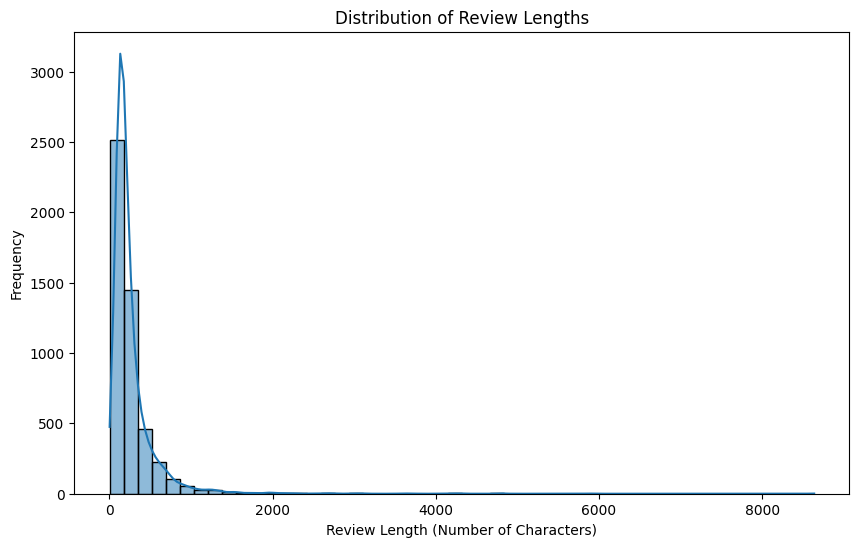

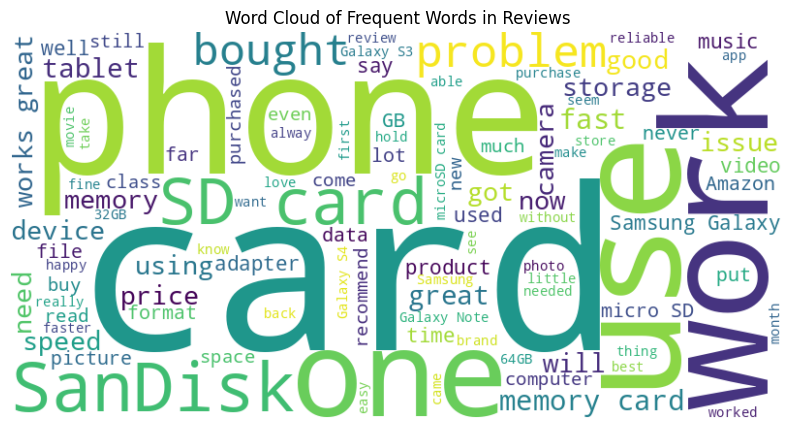

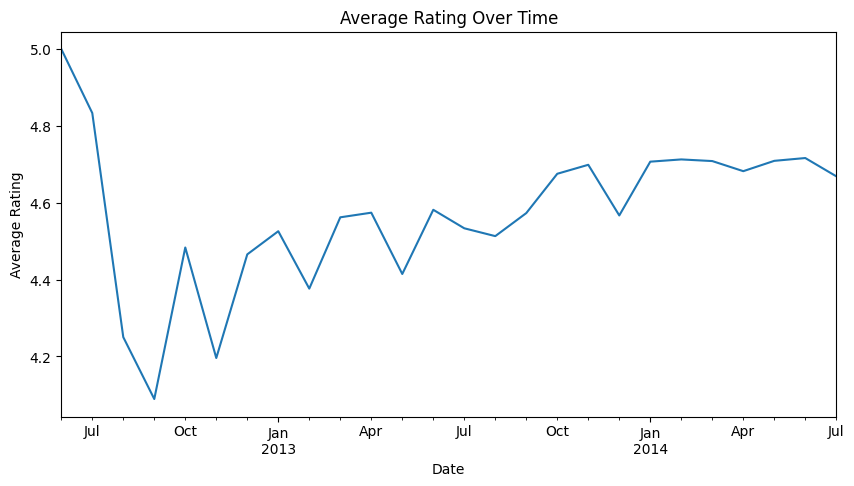

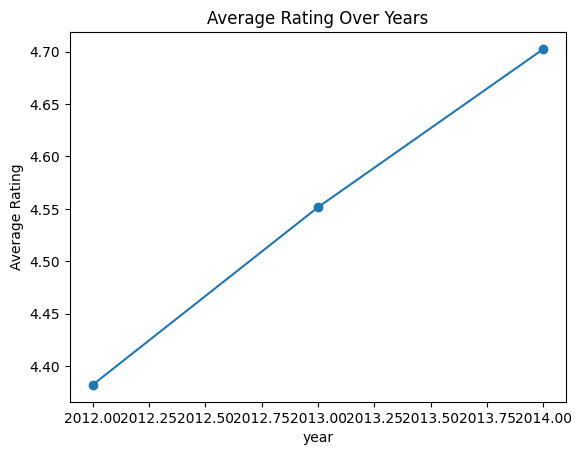

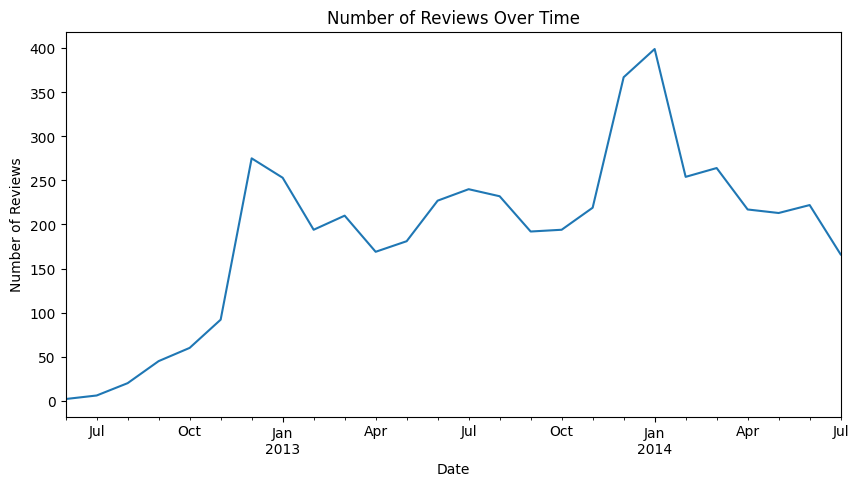

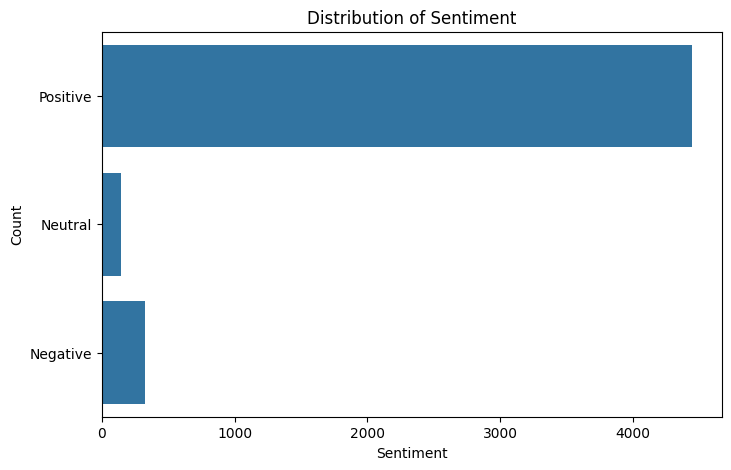

In [3]:
# 1. Distribution of Ratings
plt.figure(figsize=(8, 5))
sns.countplot(data['overall'])
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

# 2. Review Length Distribution
if 'reviewText' in data.columns:
    data['review_length'] = data['reviewText'].str.len()
    plt.figure(figsize=(10, 6))
    sns.histplot(data['review_length'], bins=50, kde=True)
    plt.title('Distribution of Review Lengths')
    plt.xlabel('Review Length (Number of Characters)')
    plt.ylabel('Frequency')
    plt.show()

# 3. Word Cloud for Most Frequent Words in Reviews
if 'reviewText' in data.columns:
    text = ' '.join(review for review in data['reviewText'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Frequent Words in Reviews')
    plt.show()

# 4. Distribution of Ratings Over Time (monthly)
plt.figure(figsize=(10, 5))
data.set_index('date')['overall'].resample('M').mean().plot()
plt.title('Average Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.show()

# 5. Yearly trend
data['year'] = data['date'].dt.year
yearly_trend = data.groupby('year')['overall'].mean()
yearly_trend.plot(kind='line', marker='o')
plt.title('Average Rating Over Years')
plt.ylabel('Average Rating')
plt.show()

# 6. Number of Reviews Over Time
plt.figure(figsize=(10, 5))
data.set_index('date').resample('M').size().plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()


# 7. Sentiment Analysis Preparation
# we can categorize ratings into Positive (4-5 stars), Neutral (3 stars), and Negative (1-2 stars)
data['sentiment'] = data['overall'].apply(lambda x: 'Positive' if x >= 4 else ('Neutral' if x == 3 else 'Negative'))
plt.figure(figsize=(8, 5))
sns.countplot(data['sentiment'])
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()




---


# Roadmap:

# 1. Feature Engineering:

Extracting and transforming data features to improve model performance.

Since I am working with text data, the primary task is to convert the text into numerical features that can be fed into machine learning models.I will use TF-IDF vectorization to transform the reviewText into numerical form.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizing the review text using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # Adjust max_features as needed
X = vectorizer.fit_transform(data['reviewText'])

# Optional: Add additional features if you have any (e.g., review length, helpful votes)
# For example:
data['review_length'] = data['reviewText'].apply(len)
X_additional = data[['review_length']]  # Example of an additional feature

# You can concatenate additional features to the TF-IDF matrix if needed
import scipy.sparse as sp
X = sp.hstack([X, sp.csr_matrix(X_additional)])  # Combine TF-IDF features with additional features

print("Feature matrix shape:", X.shape)


Feature matrix shape: (4913, 1001)




---


**The feature matrix shape (4913, 1001) indicates that I have 4913 samples (reviews) and 1001 features. These features consist of the 1000 TF-IDF features plus 1 additional feature (review_length)**


---



#  2. Data Splitting:

Spliting the data into training and testing sets to evaluate the model’s performance.

so I  split the data for both sentiment analysis (**classification**) and rating prediction (**regression**).

In [5]:
from sklearn.model_selection import train_test_split

# Target variables
y_sentiment = data['sentiment']  # Target for sentiment analysis (classification)
y_rating = data['overall']  # Target for rating prediction (regression)

# Splitting the data for sentiment analysis
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(X, y_sentiment, test_size=0.2, random_state=42)

# Splitting the data for rating prediction
X_train_rating, X_test_rating, y_train_rating, y_test_rating = train_test_split(X, y_rating, test_size=0.2, random_state=42)

print("Sentiment analysis - Training set shape:", X_train_sent.shape)
print("Rating prediction - Training set shape:", X_train_rating.shape)


Sentiment analysis - Training set shape: (3930, 1001)
Rating prediction - Training set shape: (3930, 1001)




---


**Sentiment Analysis Training Set:** 3930 samples with 1001 features.

**Rating Prediction Training Set:** 3930 samples with 1001 features.

This indicates that **both training sets contain 80% of the original data (as expected with a 80/20 split).**



---


# **Model Selection:**

Determining which machine learning models work best.


I will choose a set of models to test for both sentiment analysis (classification) and rating prediction (regression).

For **classification** (sentiment analysis), start with models like Logistic Regression or Naive Bayes.

For **regression** (rating prediction), consider Linear Regression, Ridge Regression, or Gradient Boosting models.



---


# **1. Sentiment Analysis (Classification):**

I will implement the Logistic Regression , Naive Bayes, SVM and Random Forest

Evaluate the model using metrics like accuracy, precision, recall, and F1-score.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Scale the data
scaler = StandardScaler(with_mean=False)
X_train_sent = scaler.fit_transform(X_train_sent)
X_test_sent = scaler.transform(X_test_sent)

# Model 1: Logistic Regression with class weights to handle class imbalance
model_lr = LogisticRegression(class_weight='balanced', max_iter=1000)
model_lr.fit(X_train_sent, y_train_sent)
pred_lr = model_lr.predict(X_test_sent)

# Model 2: Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train_sent, y_train_sent)
pred_nb = model_nb.predict(X_test_sent)

# Model 3: SVM
model_svm = SVC(kernel='linear')
model_svm.fit(X_train_sent, y_train_sent)
pred_svm = model_svm.predict(X_test_sent)

# Model 4: Random Forest
model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model_rf.fit(X_train_sent, y_train_sent)
pred_rf = model_rf.predict(X_test_sent)

# Evaluate the models
print("Logistic Regression (with class weights) Classification Report:")
print(classification_report(y_test_sent, pred_lr))
print("Confusion Matrix for Logistic Regression (with class weights):")
print(confusion_matrix(y_test_sent, pred_lr))

print("\nNaive Bayes Classification Report:")
print(classification_report(y_test_sent, pred_nb))
print("Confusion Matrix for Naive Bayes:")
print(confusion_matrix(y_test_sent, pred_nb))

print("\nSVM Classification Report:")
print(classification_report(y_test_sent, pred_svm))
print("Confusion Matrix for SVM:")
print(confusion_matrix(y_test_sent, pred_svm))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test_sent, pred_rf))
print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test_sent, pred_rf))


Logistic Regression (with class weights) Classification Report:
              precision    recall  f1-score   support

    Negative       0.59      0.53      0.56        68
     Neutral       0.07      0.12      0.09        25
    Positive       0.95      0.94      0.95       890

    accuracy                           0.89       983
   macro avg       0.54      0.53      0.53       983
weighted avg       0.91      0.89      0.90       983

Confusion Matrix for Logistic Regression (with class weights):
[[ 36  11  21]
 [  2   3  20]
 [ 23  27 840]]

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    Negative       0.37      0.63      0.47        68
     Neutral       0.09      0.24      0.13        25
    Positive       0.97      0.87      0.92       890

    accuracy                           0.84       983
   macro avg       0.48      0.58      0.50       983
weighted avg       0.91      0.84      0.87       983

Confusion Matrix for Naive Ba

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Scale the data
scaler = StandardScaler(with_mean=False)
X_train_sent = scaler.fit_transform(X_train_sent)
X_test_sent = scaler.transform(X_test_sent)

# Model 1: Logistic Regression with increased max_iter
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_sent, y_train_sent)
pred_lr = model_lr.predict(X_test_sent)

# Model 2: Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train_sent, y_train_sent)
pred_nb = model_nb.predict(X_test_sent)

# Model 3: SVM
model_svm = SVC(kernel='linear')
model_svm.fit(X_train_sent, y_train_sent)
pred_svm = model_svm.predict(X_test_sent)

# Model 4: Random Forest
model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model_rf.fit(X_train_sent, y_train_sent)
pred_rf = model_rf.predict(X_test_sent)

# Evaluate the models
print("Logistic Regression Classification Report:")
print(classification_report(y_test_sent, pred_lr))
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test_sent, pred_lr))

print("\nNaive Bayes Classification Report:")
print(classification_report(y_test_sent, pred_nb))
print("Confusion Matrix for Naive Bayes:")
print(confusion_matrix(y_test_sent, pred_nb))

print("\nSVM Classification Report:")
print(classification_report(y_test_sent, pred_svm))
print("Confusion Matrix for SVM:")
print(confusion_matrix(y_test_sent, pred_svm))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test_sent, pred_rf))
print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test_sent, pred_rf))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       0.64      0.50      0.56        68
     Neutral       0.10      0.12      0.11        25
    Positive       0.95      0.96      0.96       890

    accuracy                           0.91       983
   macro avg       0.56      0.53      0.54       983
weighted avg       0.91      0.91      0.91       983

Confusion Matrix for Logistic Regression:
[[ 34   9  25]
 [  2   3  20]
 [ 17  18 855]]

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    Negative       0.37      0.63      0.47        68
     Neutral       0.09      0.24      0.13        25
    Positive       0.97      0.87      0.92       890

    accuracy                           0.84       983
   macro avg       0.48      0.58      0.50       983
weighted avg       0.91      0.84      0.87       983

Confusion Matrix for Naive Bayes:
[[ 43  12  13]
 [  8   6  11]
 [ 64  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



# Model Comparison and Insights:

**1. Logistic Regression (with class weights):**

Accuracy: 91%

Precision and Recall:

Negative Class: Precision (0.64), Recall (0.50)

Neutral Class: Precision (0.10), Recall (0.12)

Positive Class: Precision (0.95), Recall (0.96)

Strengths: Performs well for the "Positive" class, which is the majority class.
Weaknesses: Still struggles with the "Neutral" and "Negative" classes, indicating that class imbalance is a significant challenge even with balanced class weights.

**2. Naive Bayes:**

Accuracy: 84%

Precision and Recall:

Negative Class: Precision (0.37), Recall (0.63)

Neutral Class: Precision (0.09), Recall (0.24)

Positive Class: Precision (0.97), Recall (0.87)

Strengths: Improved recall for the "Negative" class compared to other models.
Weaknesses: Still struggles with the "Neutral" class, with both precision and recall being low.

**3. SVM:**

Accuracy: 90%

Precision and Recall:

Negative Class: Precision (0.54), Recall (0.56)

Neutral Class: Precision (0.12), Recall (0.16)

Positive Class: Precision (0.96), Recall (0.94)

Strengths: Better balance in performance across all classes compared to other models.
Weaknesses: The "Neutral" class remains difficult to predict accurately.

**4. Random Forest:**

Accuracy: 91%

Precision and Recall:

Negative Class: Precision (1.00), Recall (0.01)

Neutral Class: Precision (0.00), Recall (0.00)

Positive Class: Precision (0.91), Recall (1.00)

Strengths: Very strong performance for the "Positive" class but at the expense of the other classes.
Weaknesses: Fails to predict the "Negative" and "Neutral" classes effectively, leading to ill-defined metrics.

**Class Imbalance Remains a Significant Challenge:** Despite using class weights in Logistic Regression, the "Neutral" and "Negative" classes still suffer from low precision and recall. This indicates that more advanced techniques might be needed to address this issue.

**Naive Bayes Handles the Negative Class Well:** Naive Bayes shows the best recall for the "Negative" class (0.63), although at the cost of lower precision. This suggests it’s more sensitive to detecting this class but may produce more false positives.

**SVM Offers the Best Overall Balance:** SVM provides a more balanced performance across all classes. Although it’s not perfect, it has a better trade-off between precision and recall compared to the other models.

**Random Forest is Overly Biased Towards the Majority Class:** Random Forest heavily favors the "Positive" class, which results in near-perfect performance for it but almost complete neglect of the "Negative" and "Neutral" classes.


# Conclusion:
**SVM** appears to be the most balanced choice so far, offering reasonable performance across all classes.

**Logistic Regression** with class weights provides decent overall performance but still struggles with class imbalance.

**Naive Bayes** is more sensitive to the minority "Negative" class, making it a good option when detecting negativity is critical.

# Hyperparameter Tuning for SVM & Logistic Regression:

In [8]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': [1, 0.1, 0.01, 0.001]  # Only applicable for 'rbf' kernel
}

grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='f1_weighted', verbose=2)
grid_svm.fit(X_train_sent, y_train_sent)

print("Best parameters for SVM:", grid_svm.best_params_)
pred_svm_tuned = grid_svm.predict(X_test_sent)
print("\nTuned SVM Classification Report:")
print(classification_report(y_test_sent, pred_svm_tuned))
print("Confusion Matrix for Tuned SVM:")
print(confusion_matrix(y_test_sent, pred_svm_tuned))

# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='f1_weighted', verbose=2)
grid_lr.fit(X_train_sent, y_train_sent)

print("Best parameters for Logistic Regression:", grid_lr.best_params_)
pred_lr_tuned = grid_lr.predict(X_test_sent)
print("\nTuned Logistic Regression Classification Report:")
print(classification_report(y_test_sent, pred_lr_tuned))
print("Confusion Matrix for Tuned Logistic Regression:")
print(confusion_matrix(y_test_sent, pred_lr_tuned))


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.9s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.9s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.9s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.2s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.9s
[CV] END ....................C=0.1, gamma=0.1, 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=0.01, class_weight=balanced, solver=saga; total time=   2.1s
[CV] END .........C=0.01, class_weight=balanced, solver=saga; total time=   0.4s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.1s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.1s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.1s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.1s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.1s
[CV] END ..........C=0.1, class_weight=balanced, solver=saga; total time=   1.3s
[CV] END ..........C=0.1, class_weight=balanced, solver=saga; total time=   1.6s
[CV] END ..........C=0.1, class_weight=balanced, solver=saga; total time=   1.3s
[CV] END ..........C=0.1, class_weight=balanced, solver=saga; total time=   3.0s
[CV] END ..........C=0.1, class_weight=balanced, solver=saga; total time=   1.5s
[CV] END .......C=1, class_w

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ............C=1, class_weight=balanced, solver=saga; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ............C=1, class_weight=balanced, solver=saga; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ............C=1, class_weight=balanced, solver=saga; total time=   2.0s
[CV] END ............C=1, class_weight=balanced, solver=saga; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ............C=1, class_weight=balanced, solver=saga; total time=   3.6s
[CV] END ......C=10, class_weight=balanced, solver=liblinear; total time=   0.2s
[CV] END ......C=10, class_weight=balanced, solver=liblinear; total time=   0.2s
[CV] END ......C=10, class_weight=balanced, solver=liblinear; total time=   0.1s
[CV] END ......C=10, class_weight=balanced, solver=liblinear; total time=   0.1s
[CV] END ......C=10, class_weight=balanced, solver=liblinear; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...........C=10, class_weight=balanced, solver=saga; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...........C=10, class_weight=balanced, solver=saga; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...........C=10, class_weight=balanced, solver=saga; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...........C=10, class_weight=balanced, solver=saga; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...........C=10, class_weight=balanced, solver=saga; total time=   2.5s
[CV] END .....C=100, class_weight=balanced, solver=liblinear; total time=   0.2s
[CV] END .....C=100, class_weight=balanced, solver=liblinear; total time=   0.2s
[CV] END .....C=100, class_weight=balanced, solver=liblinear; total time=   0.2s
[CV] END .....C=100, class_weight=balanced, solver=liblinear; total time=   0.2s
[CV] END .....C=100, class_weight=balanced, solver=liblinear; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=100, class_weight=balanced, solver=saga; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=100, class_weight=balanced, solver=saga; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=100, class_weight=balanced, solver=saga; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=100, class_weight=balanced, solver=saga; total time=   2.0s
[CV] END ..........C=100, class_weight=balanced, solver=saga; total time=   2.0s
Best parameters for Logistic Regression: {'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear'}

Tuned Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       0.57      0.54      0.56        68
     Neutral       0.09      0.12      0.10        25
    Positive       0.95      0.95      0.95       890

    accuracy                           0.90       983
   macro avg       0.54      0.54      0.54       983
weighted avg       0.91      0.90      0.90       983

Confusion Matrix for Tuned Logistic Regression:
[[ 37  10  21]
 [  3   3  19]
 [ 25  21 844]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Analysis:

**Class Imbalance Handling:**

Both models show similar struggles with the "Neutral" class, which is expected given its small representation in the dataset.
SVM performs slightly better on the "Neutral" class (Precision: 0.12, Recall: 0.16) than Logistic Regression.
Logistic Regression offers a better F1-score for the "Negative" class (0.56) compared to SVM (0.55).

**Overall Accuracy and F1-Score:**

Both models achieve a similar overall accuracy (90%).
The macro average F1-scores are the same (0.54), indicating that neither model has a clear advantage when considering performance across all classes.

**Confusion Matrix Insights:**

Both models struggle to classify the "Neutral" class correctly, often misclassifying it as "Positive."
The "Negative" class is handled similarly by both models, though Logistic Regression shows slightly better precision and recall.

**Conclusion and Recommendation:**
Logistic Regression is slightly better at predicting the "Negative" class, which might be more important depending on my use case.
SVM offers slightly better performance on the "Neutral" class but is still far from ideal.

# **2. Rating Prediction (Regression):**

I will do code for trains and evaluates four models: Linear Regression, Lasso Regression, Random Forest Regressor, and Decision Tree Regressor.

GridSearchCV is used for hyperparameter tuning for Lasso Regression, Random Forest, and Decision Tree Regressor.

The evaluation is based on RMSE and R²

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .........................................alpha=0.01; total time=   0.1s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ........................................

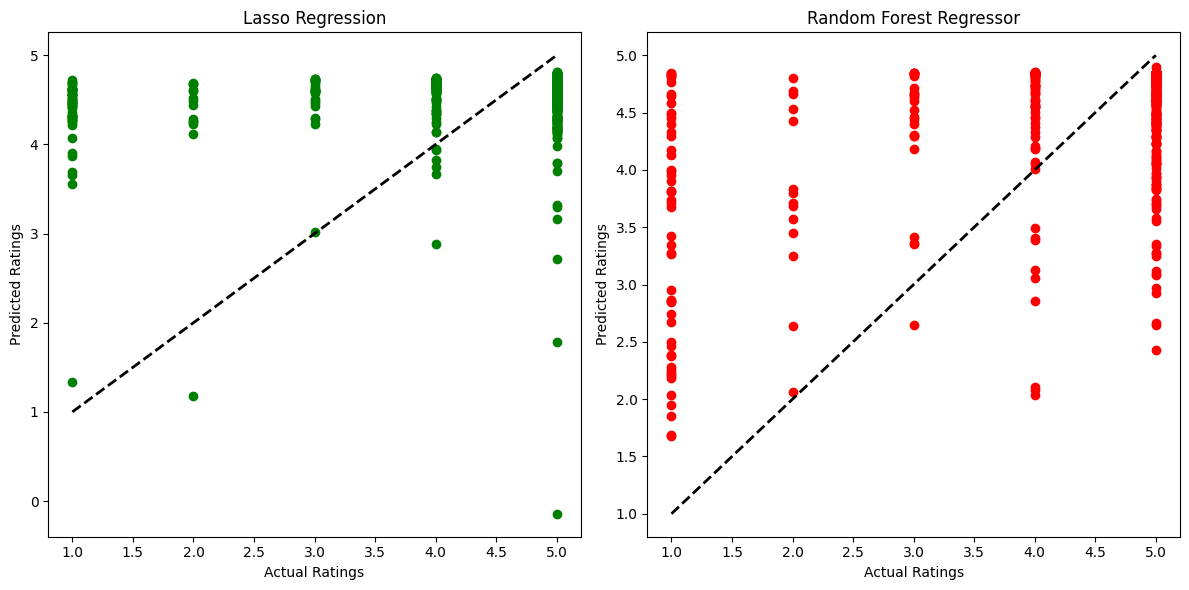

In [9]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Define the models
lasso_model = Lasso()
random_forest_model = RandomForestRegressor()

# Train and evaluate Lasso Regression
param_grid_lasso = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_lasso = GridSearchCV(lasso_model, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_lasso.fit(X_train_rating, y_train_rating)
pred_lasso = grid_lasso.predict(X_test_rating)
print(f"Best parameters for Lasso Regression: {grid_lasso.best_params_}")

# Train and evaluate Random Forest Regressor
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
}
grid_rf = GridSearchCV(random_forest_model, param_grid_rf, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_rf.fit(X_train_rating, y_train_rating)
pred_rf = grid_rf.predict(X_test_rating)
print(f"Best parameters for Random Forest: {grid_rf.best_params_}")

# Evaluate models
def evaluate_model(name, y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")

# Lasso Regression
evaluate_model("Lasso Regression", y_test_rating, pred_lasso)

# Random Forest Regressor
evaluate_model("Random Forest Regressor", y_test_rating, pred_rf)

# Visualizing the results for both models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_rating, pred_lasso, color='green')
plt.plot([y_test_rating.min(), y_test_rating.max()], [y_test_rating.min(), y_test_rating.max()], 'k--', lw=2)
plt.title("Lasso Regression")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")

plt.subplot(1, 2, 2)
plt.scatter(y_test_rating, pred_rf, color='red')
plt.plot([y_test_rating.min(), y_test_rating.max()], [y_test_rating.min(), y_test_rating.max()], 'k--', lw=2)
plt.title("Random Forest Regressor")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")

plt.tight_layout()
plt.show()


# Analysis:

**Lasso Regression:**

The RMSE of 0.99 indicates that the Lasso model has a higher prediction error compared to the Random Forest model.
The R² value of 0.05 shows that Lasso explains only 5% of the variance in the ratings, which is quite low.

**Random Forest Regressor:**

The RMSE of 0.84 is significantly better than Lasso, indicating lower prediction errors.
The R² value of 0.33 means that Random Forest explains about 33% of the variance in the ratings, making it a more reliable model compared to Lasso.

# Conclusion:

Random Forest Regressor is clearly the better-performing model for your rating prediction task based on both RMSE and R².
Lasso Regression’s low R² indicates that it is not capturing the complexity in the data effectively.